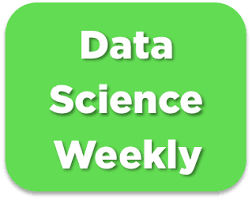

# Challenge : predict conversions 🏆🏆

This is the template that shows the different steps of the challenge. In this notebook, all the training/predictions steps are implemented for a very basic model (logistic regression with only one variable). Please use this template and feel free to change the preprocessing/training steps to get the model with the best f1-score ! May the force be with you 🧨🧨  

**For a detailed description of this project, please refer to *02-Conversion_rate_challenge.ipynb*.**

# Import libraries

In [2]:
pip install plotly -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "iframe" # to be replaced by "iframe" if working on JULIE
from IPython.display import display

# Read file with labels

In [2]:
data = pd.read_csv('conversion_data_train.csv')
print('Set with labels (our train+test) :', data.shape)

Set with labels (our train+test) : (284580, 6)


In [3]:
data.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [5]:
data.describe(include = 'all')

,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


## Country

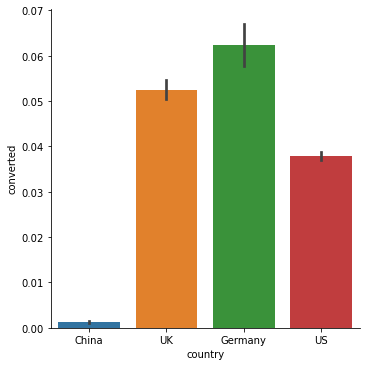

In [6]:
#moyenne de converted en fonction du pays
sns.catplot(data = data, x = 'country', y = 'converted', kind = 'bar')

## Age

In [4]:
np.sort(data['age'].unique())

array([ 17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,
        30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  70,  72,  73,  77,  79, 111, 123])

In [5]:
data = data.loc[data['age']<100,:]

<AxesSubplot:xlabel='age', ylabel='Count'>

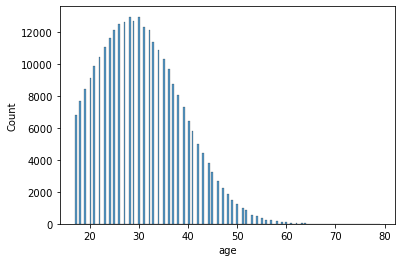

In [10]:
sns.histplot(data.age)

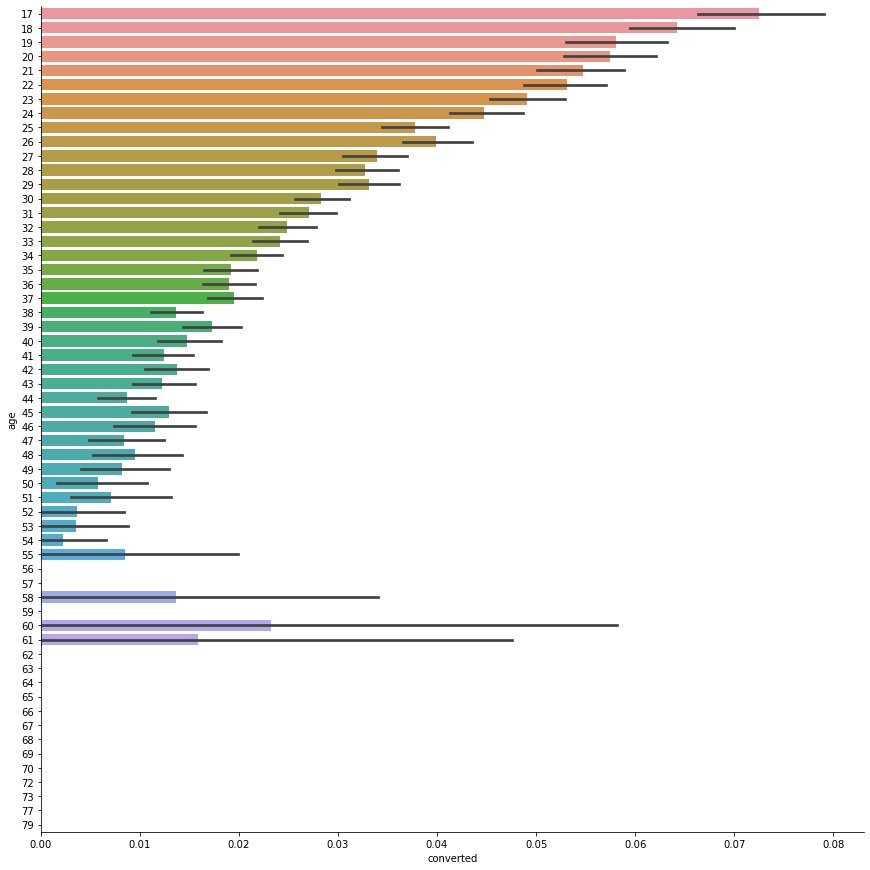

In [4]:
#moyenne de converted en fonction de l'age
sns.catplot(data=data, y = 'age', x = 'converted', kind = 'bar',orient = 'h',height=12)

## total page visited

<AxesSubplot:xlabel='total_pages_visited', ylabel='Count'>

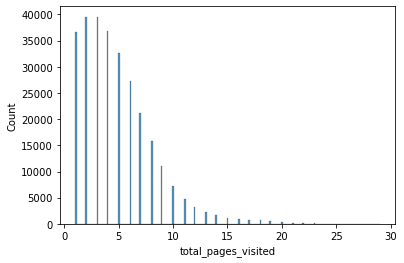

In [35]:
sns.histplot(data.total_pages_visited)

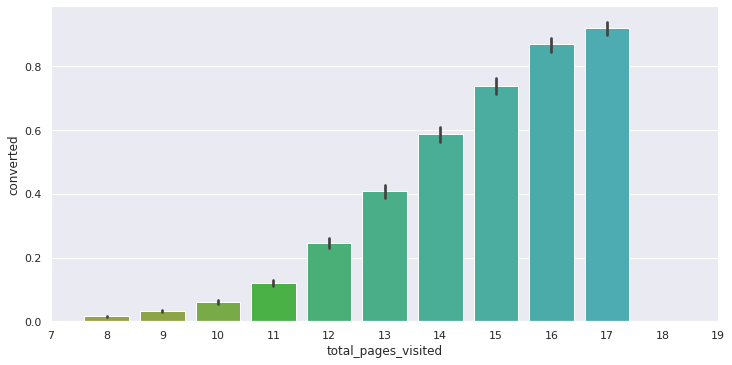

In [323]:
g = sns.catplot(data = data1, x = data['total_pages_visited'], y = 'converted', kind = 'bar',aspect = 2)
g.set(xlim = (6,18))

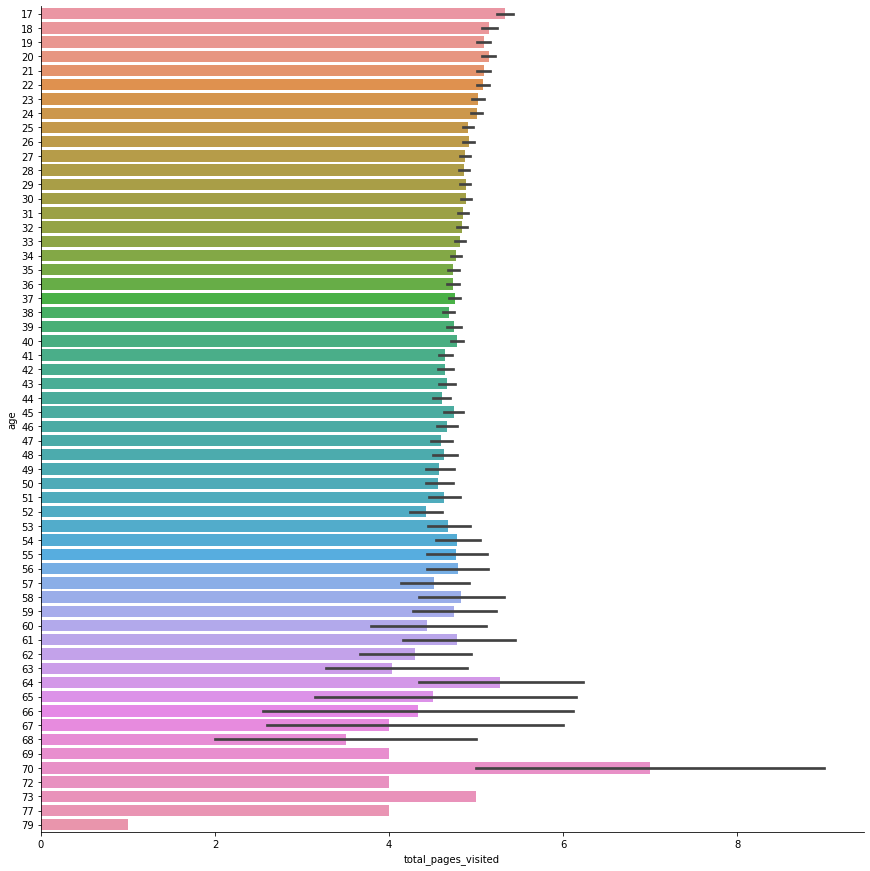

In [13]:
#nb de pages visités en moyenne en fonction de l'age
sns.catplot(data=data, y = 'age', x = 'total_pages_visited', kind = 'bar', orient = 'h', height = 12)

In [14]:
data.new_user.value_counts()

1    195066
0     89512
Name: new_user, dtype: int64

In [17]:
nu_0 = data.loc[data.new_user == 0, 'converted'].value_counts()
nu_1 = (data.loc[data.new_user == 1, 'converted'].value_counts())
print((nu_1[1]/(nu_1[0]+nu_1[1]))/(nu_0[1]/(nu_0[0]+nu_0[1])))
print('converted for new user = 0:\n', nu_0, '\nconverted for new user = 1:\n', nu_1)

0.19540029218027952
converted for new user = 0:
 0    83075
1     6437
Name: converted, dtype: int64 
converted for new user = 1:
 0    192325
1      2741
Name: converted, dtype: int64


## Source

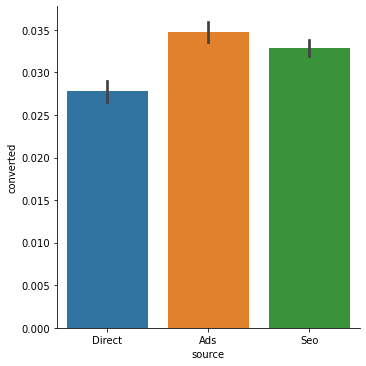

In [19]:
sns.catplot(data=data, x='source', y='converted', kind = 'bar')

<AxesSubplot:xlabel='source', ylabel='Count'>

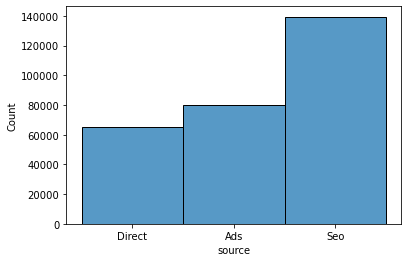

In [20]:
sns.histplot(data.source)

# Make your model

### séparer les données en fonction du nombre de pages

In [15]:
data0 = data.loc[data.age<=(data.age.mean()+3*data.age.std()),:]

In [16]:
data1 = data0.loc[(data['total_pages_visited']<=17) & (data['total_pages_visited']>= 8) & (data['country'] != 'China'),:]
data2 = data0.loc[(data['total_pages_visited']>17) | (data['total_pages_visited']< 8) |(data['country'] == 'China'),:]

## Choose variables to use in the model, and create train and test sets
**From the EDA, we know that the most useful feature is total_pages_visited. Let's create a baseline model by using at first only this feature : in the next cells, we'll make preprocessings and train a simple (univariate) logistic regression.**

In [19]:
data.columns

Index(['country', 'age', 'new_user', 'source', 'total_pages_visited',
       'converted'],
      dtype='object')

In [52]:

features_list = ['country', 'age', 'new_user', 'total_pages_visited','source']
target_variable = 'converted'
features_list

['country', 'age', 'new_user', 'total_pages_visited', 'source']

In [53]:
X = data0.loc[:, features_list]
Y = data0.loc[:, target_variable]

X1 = data1.loc[:, features_list]
Y1 = data1.loc[:, target_variable]

X2 = data2.loc[:, features_list]
Y2 = data2.loc[:, target_variable]

print('Explanatory variables : ', X.columns)
print()

Explanatory variables :  Index(['country', 'age', 'new_user', 'total_pages_visited', 'source'], dtype='object')



In [54]:
# Divide dataset Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.22, random_state=0,stratify = Y)

X1_train, X1_test, Y1_train, Y1_test = train_test_split(X1, Y1, test_size=0.22, random_state=0,stratify = Y1)

X2_train, X2_test, Y2_train, Y2_test = train_test_split(X2, Y2, test_size=0.22, random_state=0,stratify = Y2)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



In [55]:
# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
Y_train = Y_train.values
Y_test = Y_test.values

Y1_train = Y1_train.values
Y1_test = Y1_test.values

Y2_train = Y2_train.values
Y2_test = Y2_test.values
print("...Done")


Convert pandas DataFrames to numpy arrays...
...Done


In [56]:
numeric_features = [1,3] 
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])
categorical_features = [0] 
categorical_transformer = Pipeline(
    steps=[
    ('encoder', OneHotEncoder(drop='first'))
    ])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [57]:
X_train = preprocessor.fit_transform(X_train)
X1_train = preprocessor.transform(X1_train)
X2_train = preprocessor.transform(X2_train)

X_test = preprocessor.transform(X_test)
X1_test = preprocessor.transform(X1_test)
X2_test = preprocessor.transform(X2_test)


## Random Forest

In [38]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [46]:
RFC = RandomForestClassifier()

# Grid of values to be tested
params = {
    'max_depth': [6],
    'min_samples_leaf': [6],
    'min_samples_split': [4],
    'n_estimators': [10]         # nombre de division du dataset à tester
}
gridsearchRFC = GridSearchCV(RFC, param_grid = params, cv = 5,return_train_score = True) # cv : the number of folds to be used for CV
gridsearchRFC.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearchRFC.best_params_)
print("Best validation accuracy : ", gridsearchRFC.best_score_)


...Done.
Best hyperparameters :  {'max_depth': 6, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 10}
Best validation accuracy :  0.9843924770636405


In [47]:
Y_pred_RFC_test = gridsearchRFC.best_estimator_.predict(X_test)
Y_pred_RFC_train = gridsearchRFC.best_estimator_.predict(X_train)

print(f1_score(Y_test, Y_pred_RFC_test),f1_score(Y_train, Y_pred_RFC_train))

0.7193791946308724 0.7286490337518925


In [64]:
# 'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 4, 'n_estimators': 40
#'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 10

In [111]:
gridsearchRFC.cv_results_.keys()
RFC_score = pd.DataFrame({'param_max_depth' : gridsearchRFC.cv_results_['param_max_depth'],\
                          'param_min_samples_leaf' : gridsearchRFC.cv_results_['param_min_samples_leaf'],\
                          'param_min_samples_split' : gridsearchRFC.cv_results_['param_min_samples_split'],\
                          'param_n_estimators' : gridsearchRFC.cv_results_['param_n_estimators'],\
                          'train_score' : gridsearchRFC.cv_results_['mean_train_score'],\
                          'test_score' : gridsearchRFC.cv_results_['mean_test_score']
                         })

score = RFC_score.loc[(RFC_score['param_min_samples_split'] == 4) & (RFC_score['param_n_estimators'] == 30),:  ]


In [114]:
fig = go.Figure()
fig.add_trace(go.Scatter3d(z=RFC_score['test_score'], x=RFC_score['param_min_samples_leaf'], y=(RFC_score['param_max_depth']),mode = 'markers', name = 'test'))
fig.add_trace(go.Scatter3d(z=RFC_score['train_score'], x=RFC_score['param_min_samples_leaf'], y=(RFC_score['param_max_depth']),mode = 'markers',name = 'train'))

fig.update_layout(title='parameters evaluation on test set', autosize=True, 
                  scene = dict(
                      zaxis = dict(nticks=4, range=[0.98,0.99], title = 'score'),
                      xaxis = dict(title = 'min_leaf'),
                      yaxis = dict(title = 'max depth')
                  )
                 )
                 
fig.show()

In [115]:
score = RFC_score.loc[(RFC_score['param_min_samples_leaf'] == 2) & (RFC_score['param_max_depth'] == 6),:  ]
 
fig = go.Figure()
fig.add_trace(go.Scatter3d(z=RFC_score['test_score'], x=RFC_score['param_min_samples_split'], y=(RFC_score['param_n_estimators']),mode = 'markers', name = 'test'))
fig.add_trace(go.Scatter3d(z=RFC_score['train_score'], x=RFC_score['param_min_samples_split'], y=(RFC_score['param_n_estimators']),mode = 'markers',name = 'train'))

fig.update_layout(title='parameters evaluation on test set', autosize=True, 
                  scene = dict(
                      zaxis = dict(range=[0.98,0.99], title = 'score'),
                      xaxis = dict(title = 'min_split'),
                      yaxis = dict(title = 'n estimator')
                  )
                 )
                 
fig.show()

In [40]:
#data1
print(gridsearchRFC.best_estimator_.score(X1_test,Y1_test))
gridsearchRFC.best_estimator_.score(X1_train,Y1_train)

0.8925404277516954


0.8987044604816973

In [53]:
YRFC_test_pred = gridsearchRFC.best_estimator_.predict(X_test)
YRFC_train_pred = gridsearchRFC.best_estimator_.predict(X_train)

In [41]:
YRFC1_test_pred = gridsearchRFC.best_estimator_.predict(X1_test)
YRFC1_train_pred = gridsearchRFC.best_estimator_.predict(X1_train)

In [43]:
YRFC2_test_pred = gridsearchRFC.best_estimator_.predict(X2_test)
YRFC2_train_pred = gridsearchRFC.best_estimator_.predict(X2_train)

## SVM

In [172]:
SVM = SVC()

# Grid of values to be tested
params = {
    'C': [1,2,3,4,5,6,7,8,9,10],
    'gamma': [1e-3,1e-2,1e-1,1]
}
gridsearchSVC = GridSearchCV(SVM, param_grid = params, cv = 3, verbose = 3, return_train_score = True) # cv : the number of folds to be used for CV
gridsearchSVC.fit(X1_train, Y1_train)
print("...Done.")


In [156]:
print("Best hyperparameters : ", gridsearchSVC.best_params_)
print("Best validation accuracy : ", gridsearchSVC.best_score_)

Best hyperparameters :  {'C': 9, 'gamma': 0.001}
Best validation accuracy :  0.8981537837289512


In [93]:
gridsearchSVC.__dict__['cv_results_']['mean_test_score']

array([0.82656581, 0.82656581, 0.82656581, 0.89235719, 0.8930238 ,
       0.82656581, 0.82656581, 0.89603803, 0.89447294, 0.89699446,
       0.82656581, 0.89624091, 0.89679158, 0.89650175, 0.8967626 ,
       0.82656581, 0.8981248 , 0.89476277, 0.89534243, 0.8965887 ])

In [159]:
SVC_score = pd.DataFrame({'params' : gridsearchSVC.cv_results_['params'],\
                          'train_score' : gridsearchSVC.cv_results_['mean_train_score'],\
                          'test_score' : gridsearchSVC.cv_results_['mean_test_score']
                         })
SVC_score = SVC_score.loc[SVC_score['test_score']>0.85,:]
SVC_score['C'] = SVC_score.params.apply(lambda x: x['C'] )
SVC_score['gamma'] = SVC_score.params.apply(lambda x: x['gamma'] )

fig = go.Figure()
fig.add_trace(go.Scatter3d(z=SVC_score['test_score'], x=SVC_score['C'], y=np.log10(SVC_score['gamma']),mode = 'markers'))
fig.add_trace(go.Scatter3d(z=SVC_score['train_score'], x=SVC_score['C'], y=np.log10(SVC_score['gamma']),mode = 'markers'))

fig.update_layout(title='parameters evaluation on test set', autosize=True, 
                  scene = dict(
                     zaxis = dict(nticks=4, range=[0.89,0.9]))
                 )

fig.show()

In [197]:
SVM = SVC()

# Grid of values to be tested
params = {
    'C': [13],
    'gamma': [1e-3]
}
gridsearchSVC = GridSearchCV(SVM, param_grid = params, cv = 3, verbose = 3, return_train_score = True) # cv : the number of folds to be used for CV
gridsearchSVC.fit(X1_train, Y1_train)
print("...Done.")


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] C=13, gamma=0.001 ...............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=13, gamma=0.001, score=(train=0.896, test=0.901), total=   6.0s
[CV] C=13, gamma=0.001 ...............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    8.6s remaining:    0.0s


[CV]  C=13, gamma=0.001, score=(train=0.899, test=0.897), total=   5.9s
[CV] C=13, gamma=0.001 ...............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   17.0s remaining:    0.0s


[CV]  C=13, gamma=0.001, score=(train=0.898, test=0.897), total=   5.8s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   25.4s finished


...Done.


In [199]:
clf_SVC = gridsearchSVC.best_estimator_

In [198]:
#1e-3 C = 13
print('test',gridsearchSVC.best_estimator_.score(X1_test,Y1_test))
gridsearchSVC.best_estimator_.score(X1_train,Y1_train)

test 0.8938445487741262


0.897921919833058

In [1]:
SVC_score = pd.DataFrame({'params' : gridsearchSVC.cv_results_['params'],\
                          'train_score' : gridsearchSVC.cv_results_['mean_train_score'],\
                          'test_score' : gridsearchSVC.cv_results_['mean_test_score']
                         })
#SVC_score = SVC_score.loc[SVC_score['test_score']>0.85,:]
SVC_score['C'] = SVC_score.params.apply(lambda x: x['C'] )
SVC_score['gamma'] = SVC_score.params.apply(lambda x: x['gamma'] )

fig = go.Figure()
fig.add_trace(go.Scatter3d(z=SVC_score['test_score'], x=SVC_score['C'], y=np.log10(SVC_score['gamma']),mode = 'markers'))
fig.add_trace(go.Scatter3d(z=SVC_score['train_score'], x=SVC_score['C'], y=np.log10(SVC_score['gamma']),mode = 'markers'))

fig.update_layout(title='parameters evaluation on test set', autosize=True, 
                  scene = dict(
                     zaxis = dict(nticks=4, range=[0.89,0.9]))
                 )
                 
fig.show()


NameError: name 'pd' is not defined

In [200]:
#data1
Y1_train_pred = clf_SVC.predict(X1_train)
Y1_test_pred = clf_SVC.predict(X1_test)

## Linear Regression

In [72]:
# Train model for data2
print("Train model...")
classifier2 = LogisticRegression() # 
classifier2.fit(X_train, Y_train)
print("Predictions on training set...")
Y2_train_pred = classifier2.predict(X2_train)
Y2_test_pred = classifier2.predict(X2_test)


Train model...
Predictions on training set...


In [73]:
print(classifier2.score(X1_train, Y1_train))
classifier2.score(X1_test, Y1_test)

0.897091872672995


0.9004637887977167

In [46]:
Y12_test_pred = np.concatenate((YRFC1_test_pred,YRFC2_test_pred))
Y12_train_pred = np.concatenate((YRFC1_train_pred,YRFC2_train_pred))
Y12_test = np.concatenate((Y1_test,Y2_test))
Y12_train = np.concatenate((Y1_train,Y2_train))


In [58]:
# Train model for the whole dataset
print("Train model...")
classifier = LogisticRegression() # 
classifier.fit(X_train, Y_train)
print("Predictions on training set...")
Y_train_pred = classifier.predict(X_train)
Y_test_pred = classifier.predict(X_test)

Train model...
Predictions on training set...


In [64]:
print(classifier.score(X_train, Y_train))
classifier.score(X_test, Y_test)

0.9845464533251348


0.9847076173377789

In [60]:
Y_test_pred = classifier.predict(X_test)
Y_train_pred = classifier.predict(X_train)

In [61]:
print(f1_score(Y_test, Y_test_pred),f1_score(Y_train, Y_train_pred))

0.7313391109868604 0.7332384566729919


## Performance assessment

In [47]:
print("f1-score on train set with linear regression : ", f1_score(Y12_train, Y12_train_pred))
print("f1-score on test set with linear regression : ", f1_score(Y12_test, Y12_test_pred))

print("f1-score on train set with linear regression : ", f1_score(Y_train, YRFC_train_pred))
print("f1-score on test set with linear regression : ", f1_score(Y_test, YRFC_test_pred))

print("f1-score on train set with linear regression : ", f1_score(Y_train, Y_train_pred))
print("f1-score on test set with linear regression : ", f1_score(Y_test, Y_test_pred))

f1-score on train set with linear regression :  0.7395036887994636
f1-score on test set with linear regression :  0.729745712596097
f1-score on train set with linear regression :  0.7317306378909986
f1-score on test set with linear regression :  0.7361365021328459
f1-score on train set with linear regression :  0.7328650344404282
f1-score on test set with linear regression :  0.7365196078431373


In [70]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on separate set : ")
print(confusion_matrix(Y12_train, Y12_train_pred))
print()
print("Confusion matrix on joined set : ")
print(confusion_matrix(Y_train, Y_train_pred))
print()

Confusion matrix on separate set : 
[[246796   1063]
 [  2856   5404]]

Confusion matrix on joined set : 
[[246830   1030]
 [  2887   5373]]



In [54]:
# You can also check more performance metrics to better understand what your model is doing
print("Confusion matrix on separate set : ")
print(confusion_matrix(Y12_test, Y12_test_pred))
print()
print("Confusion matrix on joined set RFC : ")
print(confusion_matrix(Y_test, YRFC_test_pred))
print()
print("Confusion matrix on joined set LR : ")
print(confusion_matrix(Y_test, Y_test_pred))
print()

Confusion matrix on separate set : 
[[27385   156]
 [  301   617]]

Confusion matrix on joined set RFC : 
[[27421   119]
 [  317   601]]

Confusion matrix on joined set LR : 
[[27427   113]
 [  317   601]]



In [51]:
print(156+301,119+314,119+317)

457 433 436


### Check what's up with wrongly predicted data

In [381]:
#svc_false_train = X_train.loc[Y_train != Y_train_pred_svc,:]
#svc_false_test = X_test.loc[Y_test != Y_test_pred_svc,:]

lreg_false_train = X_train.loc[Y_train != Y_train_pred,:]
lreg_false_test = X_test.loc[Y_test != Y_test_pred,:]

X.columns

Index(['country', 'age', 'new_user', 'total_pages_visited'], dtype='object')

In [385]:
lreg_false_test.loc[lreg_false_test.country == 'china','country'].count()

0

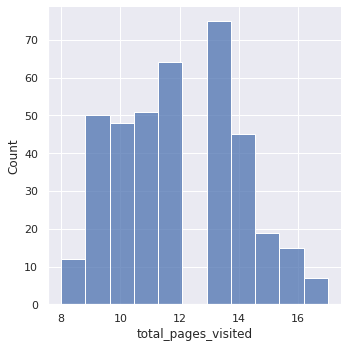

In [387]:
#sns.displot(svc_false_test.total_pages_visited)
sns.displot(lreg_false_test.total_pages_visited)

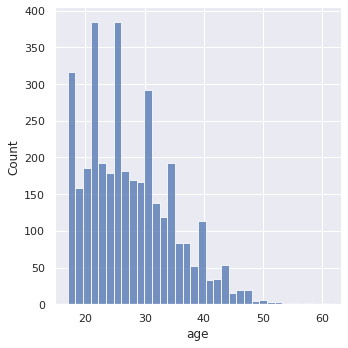

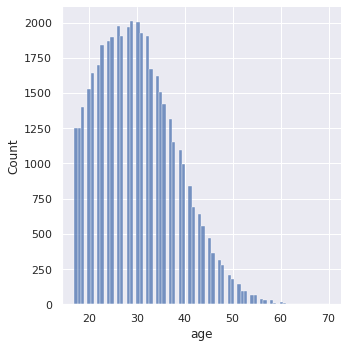

In [389]:
sns.displot(lreg_false_train.age)
sns.displot(X_train.age)

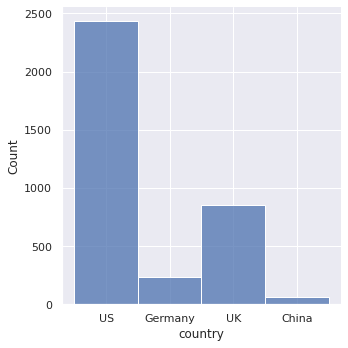

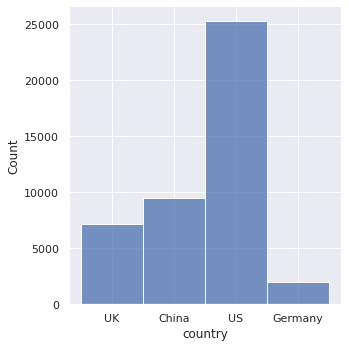

In [390]:
#sns.displot(svc_false_train.country)
sns.displot(lreg_false_train.country)
sns.displot(X_train.country)

**Our baseline model reaches a f1-score of almost 70%. Now, feel free to refine your model and try to beat this score ! 🚀🚀**

# Train best classifier on all data and use it to make predictions on X_without_labels
**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [16]:
# Concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train,X_test,axis=0)
Y = np.append(Y_train,Y_test)

classifier.fit(X,Y)

LogisticRegression()

In [17]:
# Read data without labels
data_without_labels = pd.read_csv('conversion_data_test.csv')
print('Prediction set (without labels) :', data_without_labels.shape)

# Warning : check consistency of features_list (must be the same than the features 
# used by your best classifier)
features_list = ['total_pages_visited']
X_without_labels = data_without_labels.loc[:, features_list]

# Convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")

print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to numpy arrays...
...Done
[[16]
 [ 5]
 [ 1]
 [ 6]
 [ 3]]


In [18]:
# WARNING : PUT HERE THE SAME PREPROCESSING AS FOR YOUR TEST SET
# CHECK YOU ARE USING X_without_labels
print("Encoding categorical features and standardizing numerical features...")

X_without_labels = featureencoder.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[ 3.33326238]
 [ 0.03879562]
 [-1.15919229]
 [ 0.3382926 ]
 [-0.56019834]]


In [19]:
# Make predictions and dump to file
# WARNING : MAKE SURE THE FILE IS A CSV WITH ONE COLUMN NAMED 'converted' AND NO INDEX !
# WARNING : FILE NAME MUST HAVE FORMAT 'conversion_data_test_predictions_[name].csv'
# where [name] is the name of your team/model separated by a '-'
# For example : [name] = AURELIE-model1
data = {
    'converted': classifier.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=['converted'],data=data)
Y_predictions.to_csv('conversion_data_test_predictions_EXAMPLE.csv', index=False)


## Analyzing the coefficients and interpreting the result
**In this template, we just trained a model with only one feature (total_pages_visited), so there's no analysis to be done about the feature importance 🤔**

**Once you've included more features in your model, please take some time to analyze the model's parameters and try to find some lever for action to improve the newsletter's conversion rate 😎😎**